In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import defaultdict
import argparse
import gzip
from scipy import stats
import scipy as sp
import community
import operator
import datetime
from sklearn.metrics import normalized_mutual_info_score

from network_ei import *
from get_motifs import *
from causal_emergence import *

import matplotlib.patches as mpatches
from matplotlib import gridspec
from matplotlib._png import read_png
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

%matplotlib inline

In [2]:
def grow_shrinking_network(N, m, probability=False, p0=np.exp(-12), G0=False, capacity=False):
    """Grow a network where each node adds its m links in a way that maximizes the effective information."""
    m0 = 2*m
    G = nx.complete_graph(m0)
    if G0!=False:
        G = G0.copy()
        m0 = G.number_of_nodes()
        N = N + m0
    dist_ei = []
    for node_i in range(m0, N):
        if node_i % 50 == 0:
            print(node_i)
        edges_added = [node_i]
        m_prob = np.random.randint(1,m*2-1)
        for edge_ij in range(m_prob):
            candidate_nodes = get_added_effectiveinfo(G, capacity, p0)
            for e_ij in edges_added:
                candidate_nodes.pop(e_ij, None)
            node_j = max(candidate_nodes.items(), key=operator.itemgetter(1))[0]

            if probability:
                probs = softmax(np.array(list(candidate_nodes.values()))/sum(list(candidate_nodes.values())), k=7.0)
                dist_ei.append(-sum(probs * np.log(probs)))
                node_js = np.random.multinomial(1, probs)
                node_j = np.nonzero(node_js)[0][0]
            
            G.add_edge(node_i, node_j)
            edges_added.append(node_j)

    return G, dist_ei
    
def get_added_effectiveinfo(G, capacity, p0=0.0001):
    """Create a dictionary of node:*added* effective information"""
    # for each node, "imagine" if you attached to it, then see which one would raise the average the most    
    node_i = G.number_of_nodes() + 1
    current_best = {}
    span = G.nodes()
    if capacity != False:
        capacity = int(np.random.uniform(low=(capacity/2), high=(capacity*2)))
        if capacity < len(span):
            span = np.random.choice(span, size=capacity, replace=False)

    for possible_edge in span:
        G2 = G.copy()
        G2.add_edge(node_i, possible_edge)
        ei = EI_net(G2, p0)
        current_best[possible_edge] = ei
                
    return current_best

def get_communities(graph):
    """Wrapper for community detection algorithms."""
    return community.best_partition(graph)

def softmax(A, k=1.0):
    """Softmax vector normalization."""
    A = np.array(A) if not isinstance(A, np.ndarray) else A
    A = A * k
    A = np.exp(A - A.max())
    return A / np.sum(A)

def normalized(A):
    A = np.array(A) if not isinstance(A, np.ndarray) else A
    return [float(i)/sum(A) for i in A]

In [26]:
N = 200
m = 4
cap = 50
G, _ = grow_shrinking_network(N, m, capacity=cap)

50
100
150


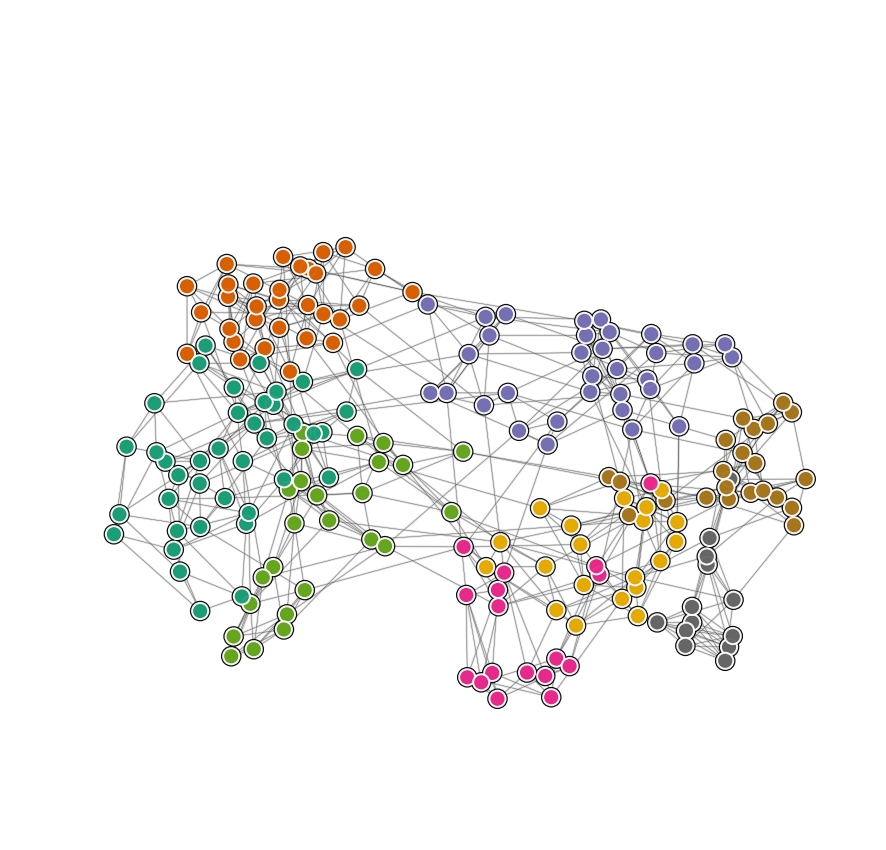

In [49]:
partition_thru_time = []
partition = community.best_partition(G, randomize=True)
partition_thru_time.append(list(partition.values()))
comms = np.array([partition[i] for i in G.nodes()])
node_colors_co = plt.cm.Dark2_r(comms)

ns = 250
# pos = nx.kamada_kawai_layout(G)
# pos = nx.spring_layout(G, k=1.05, iterations=250)
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G, pos, node_color=node_colors_co, linewidths=4, 
                       node_size=ns+25, alpha=0.95).set_edgecolor('k')
nx.draw_networkx_nodes(G, pos, node_color=node_colors_co, linewidths=2, 
                       node_size=ns+10, alpha=0.95).set_edgecolor('w')
nx.draw_networkx_edges(G, pos, edge_color="lightgrey", width=2.15, alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color="black", width=0.25, alpha=0.87)
plt.axis('off')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.5)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (63,) and (64,)

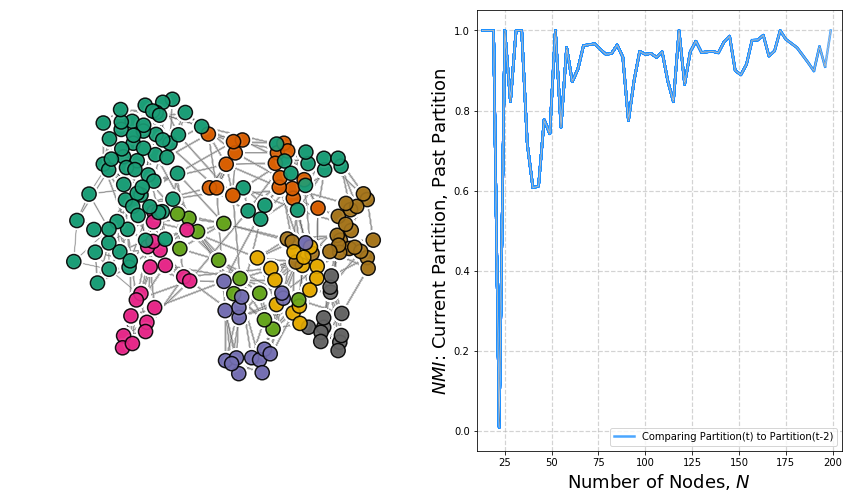

In [92]:
n_init = 10
nodelist = list(G.nodes())[:n_init]
Gsub = nx.subgraph(G, nodelist)
partition = community.best_partition(Gsub)
bywhat=3
partition_thru_time = [list(partition.values())]*bywhat
ents = [1.0]*bywhat
network_sizes = np.arange(n_init+bywhat, G.number_of_nodes(), bywhat)
ns = 200

fig, (ax0, ax1) = plt.subplots(1,2,figsize=(16*0.9,9*0.9))
for n in network_sizes:
    nodelist = list(G.nodes())[:n]
    Gsub = nx.subgraph(G, nodelist)
    partition = community.best_partition(Gsub, randomize=True)
    prev_partition = partition_thru_time[-1]
    partition_thru_time.append(list(partition.values()))
    
    A = np.array(list(partition.values()))[:-bywhat]
    B = np.array(prev_partition)
    div = normalized_mutual_info_score(A, B)
    ents.append(div)
    
    comms = np.array([partition[i] for i in Gsub.nodes()])
    node_colors_co = plt.cm.Dark2_r(comms)

    nx.draw_networkx_nodes(Gsub, pos, node_color=node_colors_co, linewidths=4, 
                           node_size=ns+25, alpha=0.95, ax=ax0).set_edgecolor('w')
    nx.draw_networkx_nodes(Gsub, pos, node_color=node_colors_co, linewidths=1.5, 
                           node_size=ns, alpha=0.9, ax=ax0).set_edgecolor('k')
    nx.draw_networkx_edges(Gsub, pos, edge_color="lightgrey", width=1.65, alpha=0.8, ax=ax0)
    nx.draw_networkx_edges(Gsub, pos, edge_color="black", width=0.25, alpha=0.87, ax=ax0)
    ax0.axis('off')
    ax0.set_xlim(-1.2,1.2)
    ax0.set_ylim(-1.2,1.2)
    
    ax1.plot(network_sizes[:len(ents)], ents, color='dodgerblue', linewidth=2.5, alpha=0.8, 
             label='Comparing Partition(t) to Partition(t-2)')
    ax1.plot(network_sizes[:len(ents)], ents, color='white', linewidth=0.75, alpha=1.0)
    ax1.plot(network_sizes[:len(ents)], ents, color='k', linewidth=0.2, alpha=1.0)
    ax1.set_xlabel("Number of Nodes, $N$", size=18)
    ax1.set_ylabel("$NMI$: Current Partition, Past Partition", size=18)
    ax1.set_xlim(n_init, G.number_of_nodes()+5)
    ax1.set_ylim(-0.05, 1.05)
    ax1.grid(True, linestyle='--', linewidth=1.2, alpha=0.55)
    if n == network_sizes[0]:
        ax1.legend(loc=4)
    plt.savefig("gifs_timshel/timshel_%04i.png"%n, dpi=200, bbox_inches='tight')

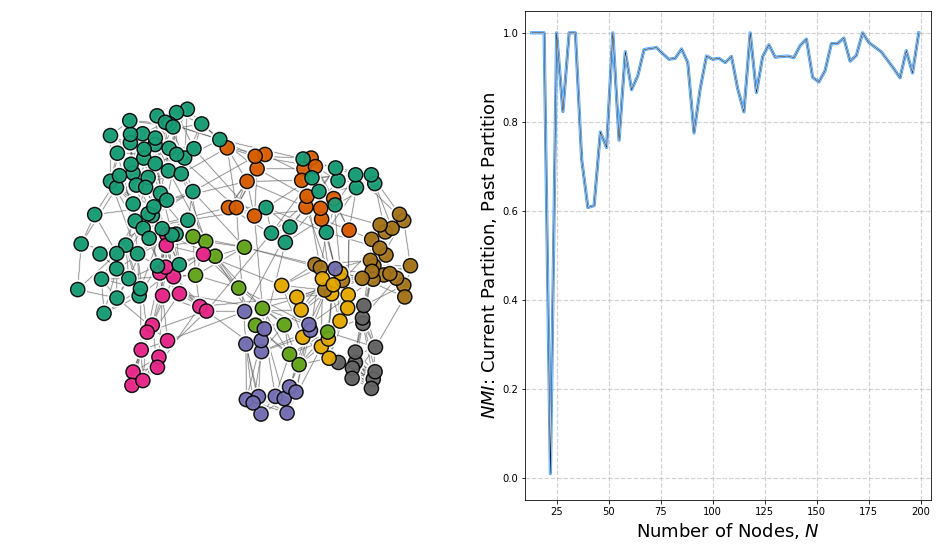

In [97]:
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(16,9))
nx.draw_networkx_nodes(Gsub, pos, node_color=node_colors_co, linewidths=4, 
                       node_size=ns+25, alpha=0.95, ax=ax0).set_edgecolor('w')
nx.draw_networkx_nodes(Gsub, pos, node_color=node_colors_co, linewidths=1.5, 
                       node_size=ns, alpha=0.9, ax=ax0).set_edgecolor('k')
nx.draw_networkx_edges(Gsub, pos, edge_color="lightgrey", width=1.65, alpha=0.8, ax=ax0)
nx.draw_networkx_edges(Gsub, pos, edge_color="black", width=0.25, alpha=0.87, ax=ax0)
ax0.axis('off')
ax0.set_xlim(-1.2,1.2)
ax0.set_ylim(-1.2,1.2)

ax1.plot(network_sizes[:len(ents)], ents[:-1], color='dodgerblue', linewidth=3.2, alpha=0.8, 
         label='Comparing Partition(t) to Partition(t-2)')
ax1.plot(network_sizes[:len(ents)], ents[:-1], color='white', linewidth=1.25, alpha=0.91)
ax1.plot(network_sizes[:len(ents)], ents[:-1], color='k', linewidth=0.5, alpha=1.0)
ax1.set_xlabel("Number of Nodes, $N$", size=18)
ax1.set_ylabel("$NMI$: Current Partition, Past Partition", size=18)
ax1.set_xlim(n_init, G.number_of_nodes()+5)
ax1.set_ylim(-0.05, 1.05)
ax1.grid(True, linestyle='--', linewidth=1.2, alpha=0.55)
# plt.savefig("timshel_blank.png", dpi=425, bbox_inches='tight')
plt.savefig("Timshel_NormalizedMI.pdf", dpi=425, bbox_inches='tight')

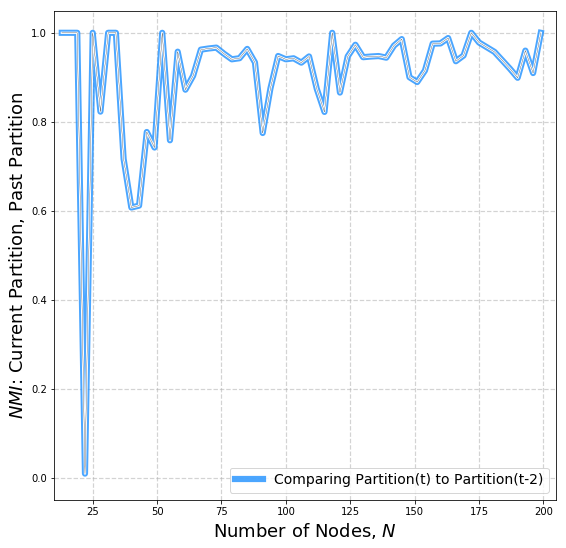

In [104]:
plt.figure(figsize=(9,9))
# nx.draw_networkx_nodes(Gsub, pos, node_color=node_colors_co, linewidths=4, 
#                        node_size=ns+25, alpha=0.95, ax=ax0).set_edgecolor('w')
# nx.draw_networkx_nodes(Gsub, pos, node_color=node_colors_co, linewidths=1.5, 
#                        node_size=ns, alpha=0.9, ax=ax0).set_edgecolor('k')
# nx.draw_networkx_edges(Gsub, pos, edge_color="lightgrey", width=1.65, alpha=0.8, ax=ax0)
# nx.draw_networkx_edges(Gsub, pos, edge_color="black", width=0.25, alpha=0.87, ax=ax0)
# ax0.axis('off')
# ax0.set_xlim(-1.2,1.2)
# ax0.set_ylim(-1.2,1.2)

plt.plot(network_sizes[:len(ents)], ents[:-1], color='dodgerblue', linewidth=6.2, alpha=0.8, 
         label='Comparing Partition(t) to Partition(t-2)')
plt.plot(network_sizes[:len(ents)], ents[:-1], color='white', linewidth=2.25, alpha=0.99)
plt.plot(network_sizes[:len(ents)], ents[:-1], color='k', linewidth=0.25, alpha=1.0)
plt.xlabel("Number of Nodes, $N$", size=18)
plt.ylabel("$NMI$: Current Partition, Past Partition", size=18)
plt.xlim(n_init, G.number_of_nodes()+5)
plt.ylim(-0.05, 1.05)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', linewidth=1.2, alpha=0.55)
# plt.savefig("timshel_blank.png", dpi=425, bbox_inches='tight')
plt.savefig("Timshel_NormalizedMI_plot.pdf", dpi=425, bbox_inches='tight')

In [110]:
n1 = network_sizes[-4]
n2 = network_sizes[-3]

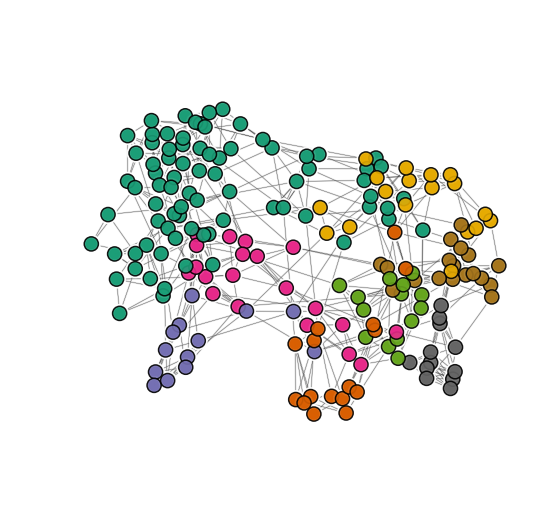

In [119]:
nodelist = list(G.nodes())[:n1]
Gsub = nx.subgraph(G, nodelist)
partition = community.best_partition(Gsub, randomize=True)
prev_partition = partition_thru_time[-1]
partition_thru_time.append(list(partition.values()))

A = np.array(list(partition.values()))
B = np.array(prev_partition)
div = normalized_mutual_info_score(A, B)
ents.append(div)

plt.figure(figsize=(9,9))
comms = np.array([partition[i] for i in Gsub.nodes()])
node_colors_co = plt.cm.Dark2_r(comms)

nx.draw_networkx_nodes(Gsub, pos, node_color=node_colors_co, linewidths=4, 
                       node_size=ns+25, alpha=0.95).set_edgecolor('w')
nx.draw_networkx_nodes(Gsub, pos, node_color=node_colors_co, linewidths=1.5, 
                       node_size=ns, alpha=0.9).set_edgecolor('k')
nx.draw_networkx_edges(Gsub, pos, edge_color="lightgrey", width=1.65, alpha=0.8)
nx.draw_networkx_edges(Gsub, pos, edge_color="black", width=0.25, alpha=0.87)
plt.axis('off')
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.savefig("Timshel_NormalizedMI_Net1.pdf", dpi=425, bbox_inches='tight')

In [120]:
nodelist = list(G.nodes())[:n2]
Gsub = nx.subgraph(G, nodelist)
partition = community.best_partition(Gsub, randomize=True)
prev_partition = partition_thru_time[-1]
partition_thru_time.append(list(partition.values()))

A = np.array(list(partition.values()))
B = np.array(prev_partition)
div = normalized_mutual_info_score(A, B)
ents.append(div)

plt.figure(figsize=(9,9))
comms = np.array([partition[i] for i in Gsub.nodes()])
node_colors_co = plt.cm.Dark2_r(comms)

nx.draw_networkx_nodes(Gsub, pos, node_color=node_colors_co, linewidths=4, 
                       node_size=ns+25, alpha=0.95).set_edgecolor('w')
nx.draw_networkx_nodes(Gsub, pos, node_color=node_colors_co, linewidths=1.5, 
                       node_size=ns, alpha=0.9).set_edgecolor('k')
nx.draw_networkx_edges(Gsub, pos, edge_color="lightgrey", width=1.65, alpha=0.8)
nx.draw_networkx_edges(Gsub, pos, edge_color="black", width=0.25, alpha=0.87)
plt.axis('off')
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.savefig("Timshel_NormalizedMI_Net2.pdf", dpi=425, bbox_inches='tight')

ValueError: labels_true and labels_pred must have same size, got 193 and 190